# PROTAC-PEDIA Data Curation

## Setup and Imports

In [1]:
from IPython.display import display_html
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import collections
import itertools
import re
import gc
import math
import numpy as np
import pandas as pd
import pickle
import requests as r
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

import typing
from typing import Mapping, Literal, Callable, List, ClassVar, Any

from uuid import uuid4
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, MACCSkeys
from datetime import date
from scipy.sparse import csr_matrix, vstack

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

pd.set_option('display.max_columns', 1000, 'display.width', 2000, 'display.max_colwidth', 100)

In [2]:
data_dir = os.path.join(os.getcwd(), '..', 'data')
src_dir = os.path.join(os.getcwd(), '..', 'src')
fig_dir = os.path.join(data_dir, 'figures')
checkpoint_dir = os.path.join(os.getcwd(), '..', 'checkpoints')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    checkpoint_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

## Data Curation

In [3]:
df_file = os.path.join(data_dir, 'raw', 'protac_pedia_20220210.csv')
protac_pedia_df = pd.read_csv(df_file)
print(protac_pedia_df.head())

   PROTACDB ID                                                                                        PROTAC SMILES Active/Inactive Best PROTAC   Cells     cLogP                              Comments        Curator   Dc50     Dmax                                                             E3 Binder SMILES E3 Ligase Ec50 of Ligand Cells Ec50 of PROTAC Cells               exit_vector  Hbond acceptors  Hbond donors Ic50 of Ligand Ic50 of PROTAC Ligand Name                                                                                        Ligand SMILES          Linker Linker Type  linker_ha  linker_no  linker_rb        MW    Off Targets Reported PATENT Ligand PDB Ligand ID      Pubmed  PROTAC Name Proteomics Data Available  Secondary Pubmed    Status  Target Tested A Non Binding E3 Control Tested Competition With Ligand Tested Engagement In Cells Tested Proteaseome Inhibitor Time    TPSA
0            1  Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CC(=O)N2CCN(CC[

In [8]:
protac_pedia_df[['PROTAC SMILES', 'Linker']].dropna(subset=['PROTAC SMILES', 'Linker']).drop_duplicates()

,PROTAC SMILES,Linker
0,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CC(=O)N2CCN(CC[C@H](CSc3ccccc...,NC(=O)CC=O
1,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCC(=O)N2CCN(CC[C@H](CSc3cccc...,NC(=O)CCC=O
2,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCC(=O)N2CCN(CC[C@H](CSc3ccc...,NC(=O)CCCC=O
3,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCC(=O)N2CCN(CC[C@H](CSc3cc...,NC(=O)CCCCC=O
4,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCC(=O)N2CCN(CC[C@H](CSc3c...,NC(=O)CCCCCC=O
...,...,...
1198,O=C(C1N(CC2=CC(Cl)=C(OCC3=CC=CC(C4=CC=C5OCCOC5=C4)=C3C)C=C2OCC6=CC=CC(C#N)=C6)CCCC1)NCCCCNC7=CC=...,CCCCN
1199,O=C(C1N(CC2=CC(Cl)=C(OCC3=CC=CC(C4=CC=C5OCCOC5=C4)=C3C)C=C2OCC6=CC=CC(C#N)=C6)CCCC1)NCCCCCNC7=CC...,CCCCCN
1200,O=C(C1N(CC2=CC(Cl)=C(OCC3=CC=CC(C4=CC=C5OCCOC5=C4)=C3C)C=C2OCC6=CC=CC(C#N)=C6)CCCC1)NCCCCCCNC7=C...,CCCCCCN
1201,O=C1N(C2CCC(NC2=O)=O)C(C3=C(NCCCCCCCC(NC(C=C4)=CC=C4N5CC6=CC=C(O)C=C6OC5=O)=O)C=CC=C31)=O,CCCCCCCC(N)=O


In [6]:
for c in protac_pedia_df.columns:
    print('-' * 80)
    print(c)
    print('-' * 80)
    display(protac_pedia_df[c].head())

--------------------------------------------------------------------------------
PROTACDB ID
--------------------------------------------------------------------------------


0    1
1    2
2    3
3    4
4    5
Name: PROTACDB ID, dtype: int64

--------------------------------------------------------------------------------
PROTAC SMILES
--------------------------------------------------------------------------------


0    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CC(=O)N2CCN(CC[C@H](CSc3ccccc...
1    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCC(=O)N2CCN(CC[C@H](CSc3cccc...
2    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCC(=O)N2CCN(CC[C@H](CSc3ccc...
3    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCC(=O)N2CCN(CC[C@H](CSc3cc...
4    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCC(=O)N2CCN(CC[C@H](CSc3c...
Name: PROTAC SMILES, dtype: object

--------------------------------------------------------------------------------
Active/Inactive
--------------------------------------------------------------------------------


0    Inactive
1    Inactive
2    Inactive
3      Active
4      Active
Name: Active/Inactive, dtype: object

--------------------------------------------------------------------------------
Best PROTAC
--------------------------------------------------------------------------------


0    No
1    No
2    No
3    No
4    No
Name: Best PROTAC, dtype: object

--------------------------------------------------------------------------------
Cells
--------------------------------------------------------------------------------


0    MOLT-4
1    MOLT-4
2    MOLT-4
3    MOLT-4
4    MOLT-4
Name: Cells, dtype: object

--------------------------------------------------------------------------------
cLogP
--------------------------------------------------------------------------------


0    10.83732
1    11.22742
2    11.61752
3    12.00762
4    12.39772
Name: cLogP, dtype: float64

--------------------------------------------------------------------------------
Comments
--------------------------------------------------------------------------------


0    IC50's are for cell viability assays
1    IC50's are for cell viability assays
2    IC50's are for cell viability assays
3    IC50's are for cell viability assays
4    IC50's are for cell viability assays
Name: Comments, dtype: object

--------------------------------------------------------------------------------
Curator
--------------------------------------------------------------------------------


0    Ronen Gabizon
1    Ronen Gabizon
2    Ronen Gabizon
3    Ronen Gabizon
4    Ronen Gabizon
Name: Curator, dtype: object

--------------------------------------------------------------------------------
Dc50
--------------------------------------------------------------------------------


0      NaN
1      NaN
2      NaN
3      NaN
4    53 nM
Name: Dc50, dtype: object

--------------------------------------------------------------------------------
Dmax
--------------------------------------------------------------------------------


0        NaN
1        NaN
2        NaN
3        NaN
4    ~ 100 %
Name: Dmax, dtype: object

--------------------------------------------------------------------------------
E3 Binder SMILES
--------------------------------------------------------------------------------


0    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](N)C(C)(C)C)cc1
1    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](N)C(C)(C)C)cc1
2    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](N)C(C)(C)C)cc1
3    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](N)C(C)(C)C)cc1
4    Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](N)C(C)(C)C)cc1
Name: E3 Binder SMILES, dtype: object

--------------------------------------------------------------------------------
E3 Ligase
--------------------------------------------------------------------------------


0    VHL
1    VHL
2    VHL
3    VHL
4    VHL
Name: E3 Ligase, dtype: object

--------------------------------------------------------------------------------
Ec50 of Ligand Cells
--------------------------------------------------------------------------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Ec50 of Ligand Cells, dtype: object

--------------------------------------------------------------------------------
Ec50 of PROTAC Cells
--------------------------------------------------------------------------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Ec50 of PROTAC Cells, dtype: object

--------------------------------------------------------------------------------
exit_vector
--------------------------------------------------------------------------------


0    morpholine_to_piperazine
1    morpholine_to_piperazine
2    morpholine_to_piperazine
3    morpholine_to_piperazine
4    morpholine_to_piperazine
Name: exit_vector, dtype: object

--------------------------------------------------------------------------------
Hbond acceptors
--------------------------------------------------------------------------------


0    17
1    17
2    17
3    17
4    17
Name: Hbond acceptors, dtype: int64

--------------------------------------------------------------------------------
Hbond donors
--------------------------------------------------------------------------------


0    5
1    5
2    5
3    5
4    5
Name: Hbond donors, dtype: int64

--------------------------------------------------------------------------------
Ic50 of Ligand
--------------------------------------------------------------------------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Ic50 of Ligand, dtype: object

--------------------------------------------------------------------------------
Ic50 of PROTAC
--------------------------------------------------------------------------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Ic50 of PROTAC, dtype: object

--------------------------------------------------------------------------------
Ligand Name
--------------------------------------------------------------------------------


0    ABT-263
1    ABT-263
2    ABT-263
3    ABT-263
4    ABT-263
Name: Ligand Name, dtype: object

--------------------------------------------------------------------------------
Ligand SMILES
--------------------------------------------------------------------------------


0    CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)...
1    CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)...
2    CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)...
3    CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)...
4    CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)...
Name: Ligand SMILES, dtype: object

--------------------------------------------------------------------------------
Linker
--------------------------------------------------------------------------------


0        NC(=O)CC=O
1       NC(=O)CCC=O
2      NC(=O)CCCC=O
3     NC(=O)CCCCC=O
4    NC(=O)CCCCCC=O
Name: Linker, dtype: object

--------------------------------------------------------------------------------
Linker Type
--------------------------------------------------------------------------------


0    Alkane
1    Alkane
2    Alkane
3    Alkane
4    Alkane
Name: Linker Type, dtype: object

--------------------------------------------------------------------------------
linker_ha
--------------------------------------------------------------------------------


0     6
1     7
2     8
3     9
4    10
Name: linker_ha, dtype: int64

--------------------------------------------------------------------------------
linker_no
--------------------------------------------------------------------------------


0    3
1    3
2    3
3    3
4    3
Name: linker_no, dtype: int64

--------------------------------------------------------------------------------
linker_rb
--------------------------------------------------------------------------------


0    2
1    3
2    4
3    5
4    6
Name: linker_rb, dtype: int64

--------------------------------------------------------------------------------
MW
--------------------------------------------------------------------------------


0    1486.282
1    1500.309
2    1514.336
3    1528.363
4    1542.390
Name: MW, dtype: float64

--------------------------------------------------------------------------------
Off Targets Reported
--------------------------------------------------------------------------------


0    No degradation of BCL2
1    No degradation of BCL2
2    No degradation of BCL2
3    No degradation of BCL2
4    No degradation of BCL2
Name: Off Targets Reported, dtype: object

--------------------------------------------------------------------------------
PATENT
--------------------------------------------------------------------------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: PATENT, dtype: object

--------------------------------------------------------------------------------
Ligand PDB
--------------------------------------------------------------------------------


0    4QNQ
1    4QNQ
2    4QNQ
3    4QNQ
4    4QNQ
Name: Ligand PDB, dtype: object

--------------------------------------------------------------------------------
Ligand ID
--------------------------------------------------------------------------------


0    1XJ
1    1XJ
2    1XJ
3    1XJ
4    1XJ
Name: Ligand ID, dtype: object

--------------------------------------------------------------------------------
Pubmed
--------------------------------------------------------------------------------


0    32145645.0
1    32145645.0
2    32145645.0
3    32145645.0
4    32145645.0
Name: Pubmed, dtype: float64

--------------------------------------------------------------------------------
PROTAC Name
--------------------------------------------------------------------------------


0             1a
1             1b
2             1c
3             1d
4    1e (DT2216)
Name: PROTAC Name, dtype: object

--------------------------------------------------------------------------------
Proteomics Data Available
--------------------------------------------------------------------------------


0    No
1    No
2    No
3    No
4    No
Name: Proteomics Data Available, dtype: object

--------------------------------------------------------------------------------
Secondary Pubmed
--------------------------------------------------------------------------------


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Secondary Pubmed, dtype: float64

--------------------------------------------------------------------------------
Status
--------------------------------------------------------------------------------


0    Reviewed
1    Reviewed
2    Reviewed
3    Reviewed
4    Reviewed
Name: Status, dtype: object

--------------------------------------------------------------------------------
Target
--------------------------------------------------------------------------------


0    Q07817
1    Q07817
2    Q07817
3    Q07817
4    Q07817
Name: Target, dtype: object

--------------------------------------------------------------------------------
Tested A Non Binding E3 Control
--------------------------------------------------------------------------------


0    No
1    No
2    No
3    No
4    No
Name: Tested A Non Binding E3 Control, dtype: object

--------------------------------------------------------------------------------
Tested Competition With Ligand
--------------------------------------------------------------------------------


0    No
1    No
2    No
3    No
4    No
Name: Tested Competition With Ligand, dtype: object

--------------------------------------------------------------------------------
Tested Engagement In Cells
--------------------------------------------------------------------------------


0     No
1     No
2     No
3     No
4    Yes
Name: Tested Engagement In Cells, dtype: object

--------------------------------------------------------------------------------
Tested Proteaseome Inhibitor
--------------------------------------------------------------------------------


0    No
1    No
2    No
3    No
4    No
Name: Tested Proteaseome Inhibitor, dtype: object

--------------------------------------------------------------------------------
Time
--------------------------------------------------------------------------------


0    48
1    48
2    48
3    48
4    48
Name: Time, dtype: object

--------------------------------------------------------------------------------
TPSA
--------------------------------------------------------------------------------


0    251.07
1    251.07
2    251.07
3    251.07
4    251.07
Name: TPSA, dtype: float64

Canonize SMILES:

In [36]:
canonize = lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x))
protac_pedia_df['PROTAC SMILES'] = protac_pedia_df['PROTAC SMILES'].apply(canonize)

Remove stereochemistry:

In [37]:
def remove_stereochemistry(smiles):
    mol = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol) # NOTE: It's a void function (returns None)
    return Chem.MolToSmiles(mol)

protac_pedia_df['PROTAC SMILES_nostereo'] = protac_pedia_df['PROTAC SMILES'].apply(remove_stereochemistry)

Drop entries with no $DC_{50}$ nor $D_{max}$ values:

In [38]:
print('Total lenght:', len(protac_pedia_df))
print('Active/Inactive lenght:', len(protac_pedia_df.dropna(subset=['Active/Inactive'])))
print('No DC50 nor Dmax lenght:', len(protac_pedia_df.dropna(subset=['Dc50', 'Dmax'])))
# protac_pedia_df = protac_pedia_df.dropna(subset=['Dc50', 'Dmax'])

Total lenght: 1203
Active/Inactive lenght: 1203
No DC50 nor Dmax lenght: 164


Remove entries with no Dmax nor DC50 values (and create copies of original columns):

In [39]:
# protac_pedia_df.dropna(subset=['Dmax'], inplace=True)
# protac_pedia_df.dropna(subset=['Dc50'], inplace=True)
protac_pedia_df['Active/Inactive (Original)'] = protac_pedia_df['Active/Inactive'].copy()
protac_pedia_df['Dmax (Original)'] = protac_pedia_df['Dmax'].copy()
protac_pedia_df['Active/Inactive'] = protac_pedia_df['Active/Inactive'].replace({'Active': True, 'Inactive': False})

Clean and convert Dmax and DC50 string entries to float:

In [40]:
def clean_string(s: str) -> str:
    if 'nan' in s or 'n/a' in s or 'NaN' in s:
        return 'nan'
    tmp = re.sub(r'[<=>]', '', s) # Remove <, >, =
    tmp = re.sub(r'\(n/a\)', '0', tmp)
    tmp = re.sub(r'NaN', '0', tmp)
    tmp = re.sub(r'[\d]+[-~]', '', tmp) # Remove range, like: 100-200 -> 200
    return tmp

def deep_clean_string(s: str) -> str:
    tmp = clean_string(s)
    tmp = re.sub(r'[~<=>% ]', '', s) # Remove ~, <, >, =, % and spaces
    return tmp

def string_to_float(s: str) -> float:
    if 'nM' in s:
        tmp = s.replace('nM', '')
        tmp = float(tmp) * 1e-9
    elif 'uM' in s:
        tmp = s.replace('uM', '')
        tmp = float(tmp) * 1e-6
    else:
        tmp = float(s)
    return tmp

In [41]:
protac_pedia_df['DC50'] = protac_pedia_df['Dc50'].apply(lambda s: string_to_float(deep_clean_string(str(s))))
protac_pedia_df['pDC50'] = -np.log10(protac_pedia_df['DC50'])
protac_pedia_df['pDC50']

0            NaN
1            NaN
2            NaN
3            NaN
4       7.275724
          ...   
1198         NaN
1199         NaN
1200         NaN
1201    6.698970
1202    7.522879
Name: pDC50, Length: 1203, dtype: float64

In [42]:
protac_pedia_df['Dmax'] = protac_pedia_df['Dmax'].apply(lambda s: string_to_float(deep_clean_string(str(s)))) / 100
protac_pedia_df['Dmax']

0       NaN
1       NaN
2       NaN
3       NaN
4       1.0
       ... 
1198    NaN
1199    NaN
1200    NaN
1201    0.9
1202    0.9
Name: Dmax, Length: 1203, dtype: float64

In [43]:
def is_active(pDC50: float, Dmax: float) -> bool:
    # NOTE: pDC50 is in negative log10 units, so to model DC50 < 100nM we just
    # need to flip the sign of the inequality.
    if pd.notnull(pDC50):
        if pDC50 < 7.0:
            return False
    if pd.notnull(Dmax):
        if Dmax < 0.8:
            return False
    if pd.notnull(pDC50) and pd.notnull(Dmax):
        return True if pDC50 >= 7.0 and Dmax >= 0.8 else False
    else:
        return float('nan')

protac_pedia_df['active'] = protac_pedia_df.apply(lambda row: is_active(row['pDC50'], row['Dmax']), axis=1)
# protac_pedia_df = protac_pedia_df.dropna(subset=['active'])
len(protac_pedia_df['active'].dropna())

427

### Plotting

Num. active entries: 101
Num. inactive entries: 326


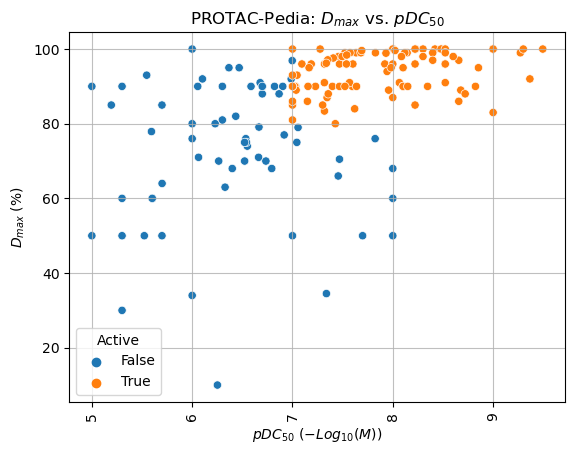

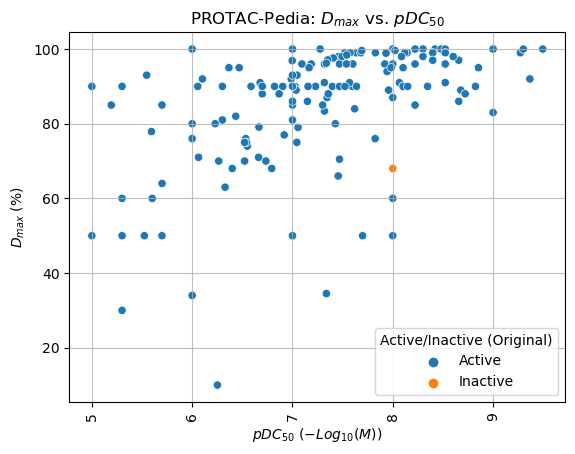

In [44]:
tmp = protac_pedia_df.copy().dropna(subset=['active'])
new_names = {
    'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
    'Dmax': '$D_{max}$ (%)',
    'active': 'Active',
}
tmp = tmp.rename(columns=new_names)
tmp['$pDC_{50}$'] = tmp['$pDC_{50}$ ($-Log_{10}(M)$)'].astype(float)
tmp['$D_{max}$ (%)'] = tmp['$D_{max}$ (%)'].astype(float) * 100

print(f'Num. active entries: {len(tmp[tmp["Active"] == True])}')
print(f'Num. inactive entries: {len(tmp[tmp["Active"] == False])}')

# _ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Treatment Hours', palette='icefire')
_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
# plt.xscale('log')
# plt.savefig(os.path.join(data_dir, 'figures', 'Dmax_percentage_vs_DC50.pdf'))
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) #, fancybox=True, shadow=True)
plt.show()


_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active/Inactive (Original)')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
# plt.xscale('log')
# plt.savefig(os.path.join(data_dir, 'figures', 'Dmax_percentage_vs_DC50.pdf'))
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) #, fancybox=True, shadow=True)
plt.show()

[]

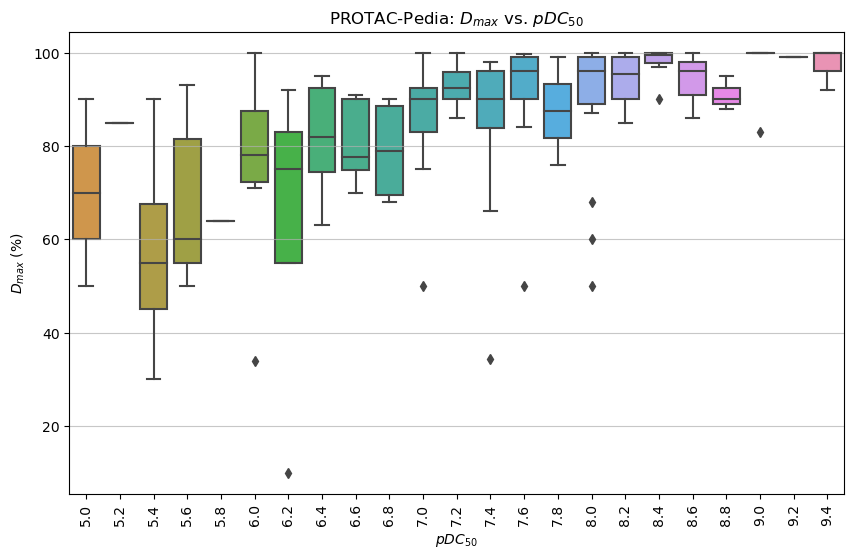

In [45]:
tmp['$D_{max}$ (%)'] = protac_pedia_df['Dmax'].astype(float) * 100
# Change the bin size by rounding
t = (tmp[['$pDC_{50}$', '$D_{max}$ (%)']] * 0.5).round(1) / 0.5
# Change plot/figure size
plt.figure(figsize=(10, 6))
sns.boxplot(data=t, x='$pDC_{50}$', y='$D_{max}$ (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.7)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
plt.plot()

[]

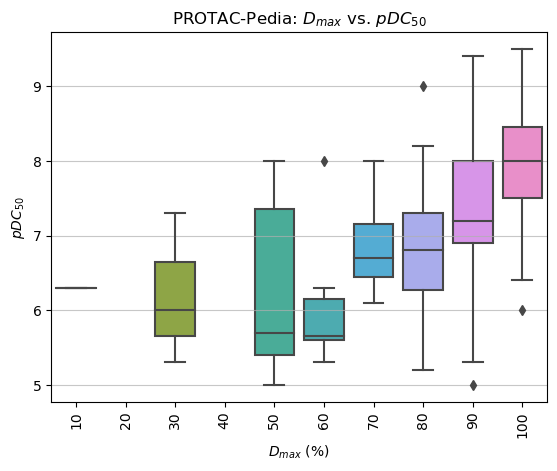

In [46]:
tmp['$D_{max}$ (%)'] = protac_pedia_df['Dmax'].astype(float)
tmp = tmp.dropna(subset=['$D_{max}$ (%)'])
# Change the bin size by rounding
t = (tmp[['$pDC_{50}$', '$D_{max}$ (%)']] * (1 / 1)).round(1) / (1 / 1)
t['$D_{max}$ (%)'] = (t['$D_{max}$ (%)'] * 100).astype(int)
_ = sns.boxplot(data=t, y='$pDC_{50}$', x='$D_{max}$ (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.7)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
plt.plot()

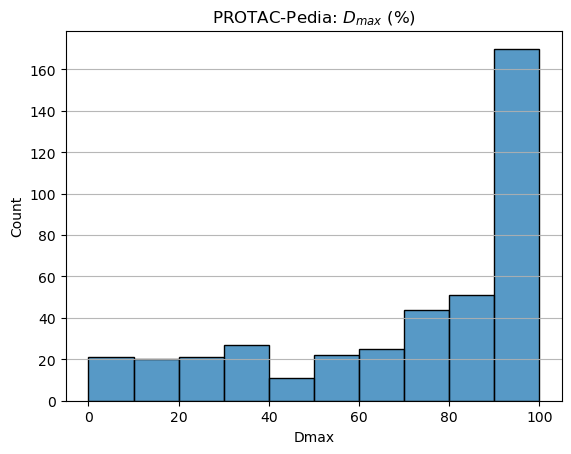

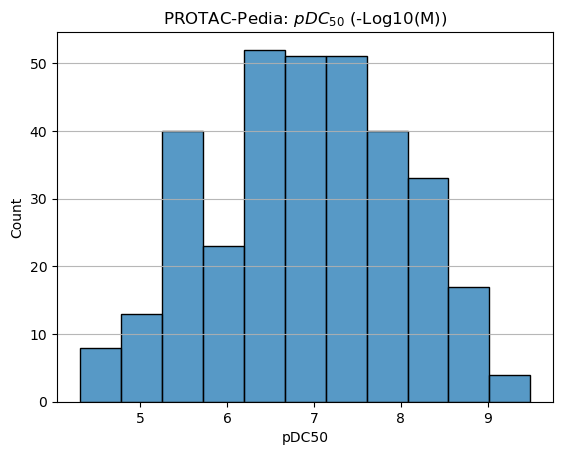

In [47]:
_ = sns.histplot(data=protac_pedia_df['Dmax'].astype(float) * 100)
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-Pedia: $D_{max}$ (%)')
plt.show()

_ = sns.histplot(data=protac_pedia_df['pDC50'])
# plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.9)
plt.title('PROTAC-Pedia: $pDC_{50}$ (-Log10(M))')
plt.show()

### E3 Ligase

#### Get Amino Acid Sequence

Assigning the gene ID to the E3 ligase entries:

In [48]:
print(protac_pedia_df['E3 Ligase'].unique())

['VHL' 'Cereblon' 'Iap' 'Mdm2' 'Ubr1' 'RNF4' 'RNF114' 'cIAP1']


In [49]:
e3ligase2genes = {
    'VHL': 'P40337',
    'CRBN': 'Q96SW2',
    'Cereblon': 'Q96SW2',
    'DCAF11': 'Q8TEB1',
    'DCAF15': 'Q66K64',
    'DCAF16': 'Q9NXF7',
    'MDM2': 'Q00987',
    'XIAP': 'P98170',
    'CIAP1': 'Q7Z460',
    'IAP': 'P98170', # I couldn't find the Uniprot ID for this one, so it's XIAP
    'AHR': 'P35869',
    'RNF4': 'P78317',
    'RNF114': 'Q9Y508',
    'FEM1B': 'Q9UK73',
    'UBR1': 'Q8IWV7',
}
protac_pedia_df['e3_ligase_gene'] = protac_pedia_df['E3 Ligase'].str.upper().map(e3ligase2genes)
protac_pedia_df['e3_ligase_gene']

0       P40337
1       P40337
2       P40337
3       P40337
4       P40337
         ...  
1198       NaN
1199       NaN
1200       NaN
1201       NaN
1202    P40337
Name: e3_ligase_gene, Length: 1203, dtype: object

In [55]:
import requests

def get_seq(uniprot_id: str, local_dict: dict) -> str:
    if pd.isna(uniprot_id):
        return None
    if ',' in uniprot_id:
        for u in uniprot_id.strip().split(','):
            if u in local_dict:
                return local_dict[u]
            else:
                ret = get_seq(u, local_dict)
                if ret is not None:
                    local_dict[u] = ret
        return None
    if uniprot_id in local_dict:
        return local_dict[uniprot_id]
    fasta_url = f'http://www.uniprot.org/uniprot/{uniprot_id}.fasta'
    try:
        response = requests.post(fasta_url)
        cData = ''.join(response.text)
        i = cData.index('\n') + 1
        seq = cData[i:].rstrip().replace('\n', '')
        # print(f'Getting {cData} from URL: {fasta_url}')
        return seq
    except:
        print(f'Error getting {uniprot_id} from URL: {fasta_url}')
        return None

In [57]:
e3_ligase_sequences_filepath = os.path.join(data_dir, 'processed', 'e3_ligase_sequences.pkl')
failed = False
if os.path.exists(e3_ligase_sequences_filepath):
    with open(e3_ligase_sequences_filepath, 'rb') as f:
        e3_seqs = pickle.load(f)
else:
    e3_seqs = {}

cID = list(set(protac_pedia_df['e3_ligase_gene'].tolist()))
for uniprot_id in cID:
    seq = get_seq(uniprot_id, e3_seqs)
    if seq is not None:
        e3_seqs[uniprot_id] = seq
    else:
        failed = True
if not failed:
    with open(e3_ligase_sequences_filepath, 'wb') as f:
        pickle.dump(e3_seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
e3_seqs['Unknown'] = 'Unknown'
print(e3_seqs.keys())

dict_keys(['Q00987', 'Q7Z460', 'P78317', 'P98170', 'Q8IWV7', 'Q9Y508', 'P40337', 'Unknown'])


In [59]:
protac_pedia_df['e3_ligase_seq'] = protac_pedia_df['e3_ligase_gene'].map(e3_seqs)
protac_pedia_df['e3_ligase_seq'].head()

0    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...
1    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...
2    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...
3    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...
4    MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...
Name: e3_ligase_seq, dtype: object

#### Aggregating E3 Ligase Classes

column: E3 Ligase  (#unique: 8)
                  0    1    2     3      4     5       6     7
E3 Ligase  Cereblon  VHL  Iap  Mdm2  cIAP1  Ubr1  RNF114  RNF4
size            691  444   42    15      7     2       1     1 



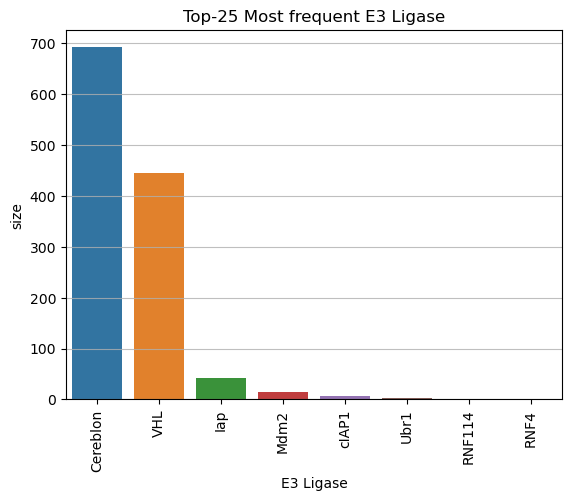

In [60]:
tmp = protac_pedia_df.groupby('E3 Ligase', as_index=False).size().sort_values('size', ascending=False, ignore_index=True)
print(f'column: E3 Ligase  (#unique: {tmp.shape[0]:,})')
print(tmp.head(20).T, '\n')
# Plotting
sns.barplot(data=tmp.head(25), x='E3 Ligase', y='size')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.8)
plt.title(f'Top-25 Most frequent E3 Ligase')
# plt.savefig(os.path.join(data_dir, 'figures', 'e3 Ligase_distribution.pdf'))
plt.show()

In [61]:
for i in range(len(protac_pedia_df['E3 Ligase'])):
    if 'IAP' in str(protac_pedia_df.at[i, 'E3 Ligase']).upper():
        protac_pedia_df.at[i, 'E3 Ligase'] = 'IAP'
    elif 'DCAF' in str(protac_pedia_df.at[i, 'E3 Ligase']):
        protac_pedia_df.at[i, 'E3 Ligase'] = 'DCAF'
    elif 'RNF' in str(protac_pedia_df.at[i, 'E3 Ligase']):
        protac_pedia_df.at[i, 'E3 Ligase'] = 'RNF'
protac_pedia_df['E3 Ligase'] = protac_pedia_df['E3 Ligase'].str.replace('Cereblon', 'CRBN')
protac_pedia_df['E3 Ligase'] = protac_pedia_df['E3 Ligase'].str.replace('Mdm2', 'MDM2')

### POI: Apply Gene Mutations

For consistency and comparison with PROTAC-DB, if sequences in PROTAC-Pedia are _not_ present in PROTAC-DB, we mark them as "Unknown":

In [63]:
poi_seq_protac_pedia_filepath = os.path.join(data_dir, 'processed', 'poi_sequences_protac_db_and_pedia.pkl')
poi_seq_protac_db_filepath = os.path.join(data_dir, 'processed', 'poi_sequences.pkl')

poi_seqs = {}
if os.path.exists(poi_seq_protac_pedia_filepath):
    with open(poi_seq_protac_pedia_filepath, 'rb') as f:
        poi_seqs.update(pickle.load(f))
if os.path.exists(poi_seq_protac_db_filepath):
    with open(poi_seq_protac_db_filepath, 'rb') as f:
        poi_seqs.update(pickle.load(f))


cID = list(set(protac_pedia_df['Target'].tolist()))
for uniprot_id in cID:
    seq = get_seq(uniprot_id, poi_seqs)
    if seq is not None:
        poi_seqs[uniprot_id] = seq
    else:
        failed = True
if not failed:
    with open(poi_seq_protac_db_filepath, 'wb') as f:
        pickle.dump(poi_seqs, f)
# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
poi_seqs['Unknown'] = 'Unknown'
print(poi_seqs.keys())

dict_keys(['Q99640', 'Q13153', 'P00519', 'Q52WX2', 'P29762', 'Q13164', 'Q16288', 'O14874', 'Q00537', 'P21802', 'O75676', 'P04629', 'O14757', 'Q15759', 'P07948', 'P41240', 'P23458', 'P45983', 'P45984', 'P30530', 'P01116', 'P54646', 'Q9UBN7', 'P51451', 'Q15208', 'Q13043', 'Q86UX6', 'P51532', 'P48729', 'Q9BYT3', 'Q13233', 'P09874', 'P78356', 'Q15418', 'Q92918', 'Q8TDR2', 'Q13470', 'O15164', 'P49841', 'O60674', 'P49840', 'P07437', 'P16591', 'O94804', 'P53355', 'Q16584', 'O75533', 'O15197', 'Q92831', 'Q9H8M2', 'P10415', 'O75460', 'Q16644', 'P31749', 'P11362', 'P49759', 'Q9UK32', 'Q9Y4K4', 'P35968', 'Q96QT4', 'Q9P2K8', 'Q15119', 'P23443', 'Q92793', 'P51686', 'Q16659', 'O75385', 'P40763', 'Q12866', 'Q9UQ88', 'Q16832', 'P29597', 'P54760', 'Q96S38', 'Q96L34', 'Q8IXJ6', 'O00444', 'P51957', 'Q7KZI7', 'Q96S53', 'Q9UBY0', 'Q9UM73', 'P08581', 'P37840', 'Q9NRH2', 'O43683', 'P42336', 'Q12834', 'Q96T83', 'Q9UGN5', 'P50613', 'O14578', 'Q15910', 'P15056', 'Q8NI60', 'P54753', 'Q96SW2', 'Q16620', 'O60285',

NOTE! Some PROTAC-Pedia entries have multiple POI targets, we will only keep the first one:

We name the new column "Uniprot" for consistency with PROTAC-DB.

In [64]:
print(f'Num. entries: {len(protac_pedia_df)}')
print(f'Num. entries with no target: {len(protac_pedia_df.dropna(subset=["Target"]))}')
protac_pedia_df = protac_pedia_df.dropna(subset=['Target'])

Num. entries: 1203
Num. entries with no target: 1203


In [65]:
protac_pedia_df.loc[:, 'Uniprot'] = protac_pedia_df.apply(lambda row: row['Target'].replace(' ', '').split(',')[0], axis=1)

Finally, get the POI sequence from the fasta-scraped sequences:

In [66]:
# protac_pedia_df['poi_seq'] = protac_pedia_df.apply(lambda row: seqs.get(row['Uniprot'], 'Unknown'), axis=1)
protac_pedia_df['poi_seq'] = protac_pedia_df['Uniprot'].map(poi_seqs)
print(len(protac_pedia_df))
print(len(protac_pedia_df[protac_pedia_df['poi_seq'] == 'Unknown']))

1203
0


Function for applying mutations:

In [67]:
def apply_mutation(uniprot: str, gene: str, seq: str):
    if len(gene.split(' ')) == 1:
        return seq
    # TODO: Just use a dictionary and replace these sequences straightaway...
    exceptions = {
        ('O60885', 'BRD4 BD1'): seqs['O60885'],
        ('P10275', 'AR-V7'): seqs['P10275'],
        ('P00533', 'EGFR e19d'): seqs['P10275'], # TODO: Not working... why???
    }
    if (uniprot, gene) in exceptions:
        return exceptions[(uniprot, gene)]
    else:
        mutation = gene.split(' ')[1]
        operations = mutation.split('/') if '/' in mutation else [mutation]
        del_ops = 0
        for op in operations:
            if 'del' in op.lower():
                idx = int(op.split('del')[1]) - 1
                print(f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]}]{seq[idx+1:idx+8]}...')
                seq = seq[:idx] + seq[idx + 1:]
                del_ops += 1
            else:
                # Replace aminoacid at a specific index
                # NOTE: The indexing starts from one, not zero.
                # NOTE: If a deletion has happened before, the index is still
                # relative to the whole sequence lenght (weird...)
                curr, idx, new = op[0].upper(), int(op[1:-1])-1, op[-1].upper()
                idx -= del_ops
                print(f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]} -> {new}]{seq[idx+1:idx+8]}...')
                assert curr == seq[idx], f'Replacement at position {idx} failed. Expected "{curr}", found: "{seq[idx]}"'
                seq = seq[:idx] + new + seq[idx + 1:]
        return seq

NOTE! There is no gene information in PROTAC-Pedia, so we cannot apply mutations to the POI sequences.

## Clean Cell Type

NOTE! Some PROTAC-Pedia entries have multiple cell types, we will only keep the first one:

In [68]:
def get_cell_type(cell):
    if ',' in str(cell):
        divider = ','
    else:
        divider = ';'
    return str(cell).replace(' ', '').split(divider)[0].rstrip()

protac_pedia_df['cell_type'] = protac_pedia_df['Cells'].fillna('Unknown')
protac_pedia_df['cell_type'] = protac_pedia_df['Cells'].apply(lambda cell: get_cell_type(cell))
print(protac_pedia_df['cell_type'])

0       MOLT-4
1       MOLT-4
2       MOLT-4
3       MOLT-4
4       MOLT-4
         ...  
1198      A549
1199       nan
1200       nan
1201      A549
1202      Huh7
Name: cell_type, Length: 1203, dtype: object


## Save DB

Save curated PROTAC-Pedia to CSV:

In [69]:
old2new = {
    'PROTAC SMILES_nostereo': 'Smiles_nostereo',
    'PROTAC SMILES': 'Smiles',
    'E3 Ligase': 'e3_ligase',
}
protac_pedia_df = protac_pedia_df.rename(columns=old2new)
protac_pedia_df['poi_gene_id'] = 'Unknown'

In [70]:
# df_file = os.path.join(data_dir, 'processed', 'protac-pedia_DC50_Dmax.csv')
# protac_pedia_df.to_csv(df_file, index=False)
df_file = os.path.join(data_dir, 'processed', 'protac_pedia_dc50_dmax.csv')
protac_pedia_df.to_csv(df_file, index=False)

## DEPRECATED: Compare with PROTAC-DB

Load PROTAC-DB training and test data:

In [82]:
TRAIN_SPLIT_PERC = 0.8
TEST_SPLIT_PERC = 1.0 - TRAIN_SPLIT_PERC

In [83]:
splitter = GroupShuffleSplit(test_size=TEST_SPLIT_PERC, n_splits=2, random_state=42)
# Split "entire" dataset
split = splitter.split(protac_db_df, groups=protac_db_df['Smiles'])
train_inds, test_inds = next(split)
train_df, test_df = protac_db_df.iloc[train_inds], protac_db_df.iloc[test_inds]
# Split datasets for binary classification
bin_df = protac_db_df.dropna(subset=['active'])
split = splitter.split(bin_df, groups=bin_df['Smiles'])
train_inds, test_inds = next(split)
train_bin_df, test_bin_df = bin_df.iloc[train_inds], bin_df.iloc[test_inds]

print(f'Train data len.: {len(train_df)}')
print(f'Test data len.: {len(test_df)}')
print(f'Train data len.: {len(train_bin_df)} (binary classification)')
print(f'Test data len.: {len(test_bin_df)} (binary classification)')

Train data len.: 353
Test data len.: 76
Train data len.: 353 (binary classification)
Test data len.: 76 (binary classification)


Get entries of PROTAC-PEDIA which are __not__ in the train dataset of PROTAC-DB (they might be used to test and compare _both_ DeepPROTACs and our approach):

In [84]:
unseen_df = protac_pedia_df[~protac_pedia_df['PROTAC SMILES_nostereo'].isin(protac_db_df['Smiles_nostereo'])]
print(len(unseen_df))

1115


Num. active entries: 51
Num. inactive entries: 297


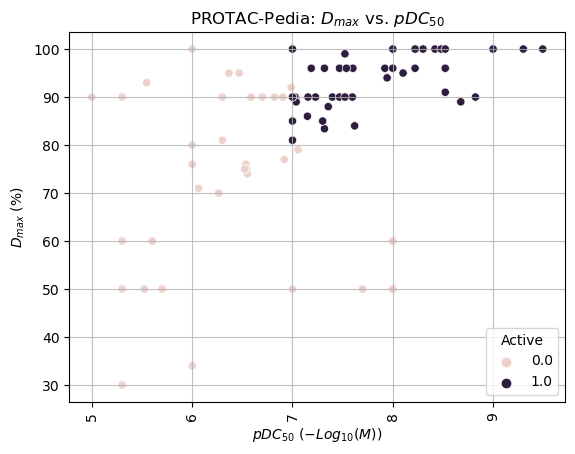

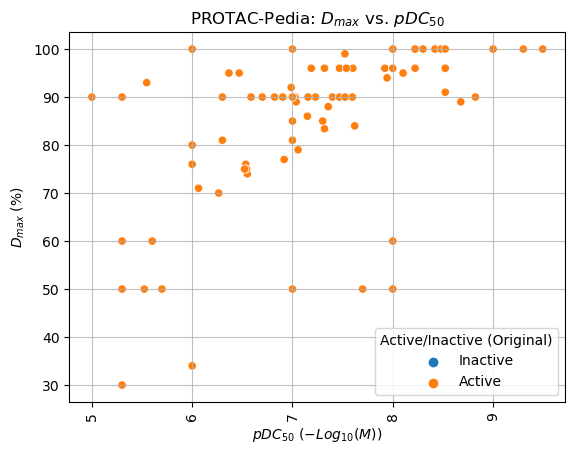

In [85]:
tmp = unseen_df.copy()
new_names = {
    'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
    'Dmax': '$D_{max}$ (%)',
    'active': 'Active',
}
tmp = tmp.rename(columns=new_names)
tmp['$pDC_{50}$'] = tmp['$pDC_{50}$ ($-Log_{10}(M)$)'].astype(float)
tmp['$D_{max}$ (%)'] = tmp['$D_{max}$ (%)'].astype(float) * 100

print(f'Num. active entries: {len(tmp[tmp["Active"] == True])}')
print(f'Num. inactive entries: {len(tmp[tmp["Active"] == False])}')

# _ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Treatment Hours', palette='icefire')
_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
# plt.xscale('log')
# plt.savefig(os.path.join(data_dir, 'figures', 'Dmax_percentage_vs_DC50.pdf'))
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) #, fancybox=True, shadow=True)
plt.show()


_ = sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)', hue='Active/Inactive (Original)')
plt.xticks(rotation=90)
plt.grid(axis='both', alpha=0.8)
plt.title('PROTAC-Pedia: $D_{max}$ vs. $pDC_{50}$')
# plt.xscale('log')
# plt.savefig(os.path.join(data_dir, 'figures', 'Dmax_percentage_vs_DC50.pdf'))
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) #, fancybox=True, shadow=True)
plt.show()

## Get E3Ligase-PROTAC-POI Complex PDBs

DeepPROTACs requires 3D information about the complexes between the E3 ligase, the PROTAC and the POI.

<!-- We will use the PDBs from the PROTAC-DB dataset. -->

In [ ]:
unseen_df['Ligand PDB'].dropna()